In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# this line ensures that all models will have the same split
np.random.seed(1882)

In [2]:
XY = np.loadtxt('phishing.data', delimiter=',')
XY = XY.astype(np.int8)

In [3]:
from src.utilz import get_random_splits

datasets = get_random_splits(XY, [0.6, 0.2, 0.2], T = 10)

In [ ]:
from src.nn import HardcodedNeuralNetwork
nn_architecture = [
    {"input_dim": 30, "output_dim": 32},
    {"input_dim": 32, "output_dim": 16},
    {"input_dim": 16, "output_dim": 1},
    # + sigmoid at the end
]
nn = HardcodedNeuralNetwork(
    nn_architecture=nn_architecture,
    epochs=100,
    learning_rate=0.01,
    batch_size=512,
)

nn.fit(datasets[0][0][:, :-1], datasets[0][0][:, -1].reshape(-1, 1))

Tutaj było uskuteczniane klipowanie wartości, żeby Python poradził sobie z overflowami  
Spójrzmy sobie co wypluło

In [86]:
nn_val_error = nn.zero_one_error(datasets[0][1][:, :-1], datasets[0][1][:, -1].reshape(-1, 1))
print(f"NN validation error: {nn_val_error}")

NN validation error: 0.15339366515837105


Tutaj nastąpiło szukanie hiperparametrów  
Empirycznie wyszło mi, że
- batch_size = 512 (mamy dość duży dataset, więc to nie jest strasznie dużo, a pomaga płynnie zbiegać)
- learning_rate = 0.01
- epochs = 100 (potem zaczynamy wyskakiwać z minimum)

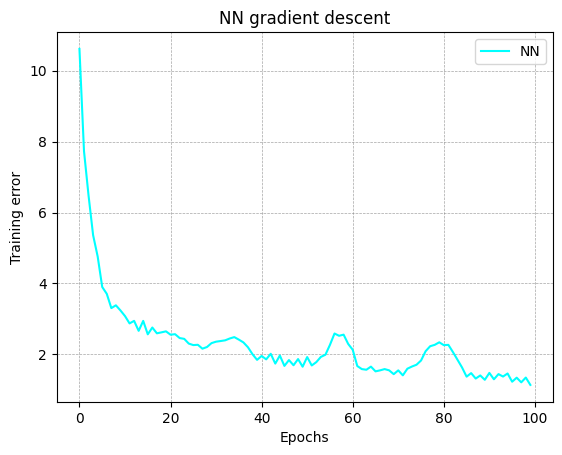

In [88]:
history = nn.get_loss_history()

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = np.arange(100), y = history,
    ax = ax, label=f'{str(nn)}', color='cyan')
ax.set(xlabel='Epochs', ylabel='Training error')
ax.set_title(f'{str(nn)} gradient descent')
plt.legend()

Fajnie to obrazuje jak SGD działa

In [90]:
from src.measures import average_error
nn.reset()

nn_test_error, nn_train_error = average_error(nn, datasets)
print(f"NN average test error: {nn_test_error}")
print(f"NN average train error: {nn_train_error}")

NN average test error: 0.19367374604609128
NN average train error: 0.18603739445114595


Czasowo wypada super - 0.32s  
Gorzej z poprawnością

In [91]:
print(f'NN average accuracy: {1 - nn_test_error}')

NN average accuracy: 0.8063262539539087


To jeszcze klasyczny wykres

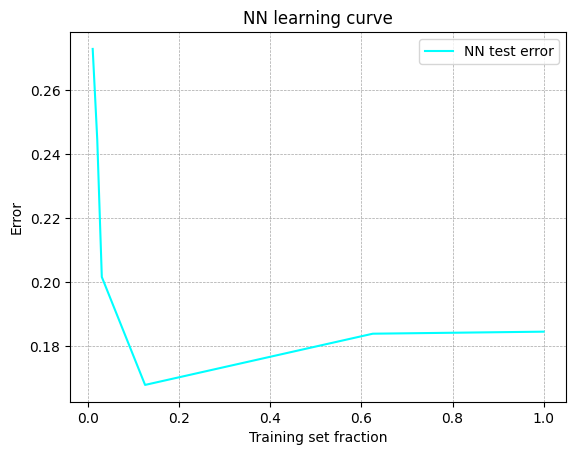

In [92]:
from src.measures import draw_learning_curve

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

nn.reset()

draw_learning_curve([nn], datasets, training_set_fractions, ['cyan'])

W sumie interesujące, że minimum jest lepsze gbybyśmy wzięli bardzo małą część zbioru  
Sanity check

In [93]:
from collections import Counter

U, W, V = datasets[7]

xy_c = Counter(XY[:, -1])
u_c = Counter(U[:, -1])
w_c = Counter(W[:, -1])
v_c = Counter(V[:, -1])


print(f"Class 1 ration in U {u_c[1] / xy_c[1]}")
print(f"Class 1 ration in W {w_c[1] / xy_c[1]}")
print(f"Class 1 ration in V {v_c[1] / xy_c[1]}")
print(f"Class -1 ration in U {u_c[-1] / xy_c[-1]}")
print(f"Class -1 ration in W {w_c[-1] / xy_c[-1]}")
print(f"Class -1 ration in V {v_c[-1] / xy_c[-1]}")


Class 1 ration in U 0.5999675166477181
Class 1 ration in W 0.19993503329543608
Class 1 ration in V 0.20009745005684587
Class -1 ration in U 0.5998366680277665
Class -1 ration in W 0.19987750102082483
Class -1 ration in V 0.20028583095140873


Nie ma się czym martwić, takie dane